# Darts
* point and probabilistic forecasting using Darts, on Energy Dataset 

In [1]:
import darts
from darts import TimeSeries
from darts.models.forecasting.forecasting_model import (LocalForecastingModel, ForecastingModel)
from darts.dataprocessing.transformers import Scaler
from darts.metrics.metrics import multi_ts_support, multivariate_support, _get_values_or_raise
from darts.logging import raise_if_not

from typing import Callable, Union, Sequence
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams['figure.figsize'] = (16,6)
import seaborn as sns
import logging
logging.getLogger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# monkey patch a method for extracting the i-th sample into darts.TimeSeries
def sample(self, i):
    new_data = self.data_array().to_numpy()[:, :, i:i+1]
    cnames = [f"{comp}_{i}" for comp in self.components]
    new_xa = xr.DataArray(
            new_data,
            dims=self.data_array().dims,
            coords={self.data_array().dims[0]: self.time_index, darts.timeseries.DIMS[1]: pd.Index(cnames)},
            attrs=self.data_array().attrs,
        )

    return self.__class__(new_xa)
    
darts.TimeSeries.sample = sample

In [3]:
@multi_ts_support
@multivariate_support
def quantile_loss(
    actual_series: Union[TimeSeries, Sequence[TimeSeries]],
    pred_series: Union[TimeSeries, Sequence[TimeSeries]],
    rho: float = 0.5,
    intersect: bool = True,
    *,
    reduction: Callable[[np.ndarray], float] = np.mean,
    inter_reduction: Callable[[np.ndarray], Union[float, np.ndarray]] = lambda x: x,
    n_jobs: int = 1,
    verbose: bool = False
) -> float:

    z_true, z_hat = _get_values_or_raise(
        actual_series,
        pred_series,
        intersect,
        stochastic_quantile=None,
        remove_nan_union=True,
    )

    if len(z_hat.shape) < 3:
        z_hat_rho = z_hat.squeeze()
    else:
        z_hat_rho = np.quantile(z_hat, q=rho, axis=2).squeeze()

    z_true = z_true.squeeze()

    pred_above = np.where(z_hat_rho >= z_true, 1, 0)
    pred_below = np.where(z_hat_rho < z_true, 1, 0)

    rho_loss = 2 * (z_true - z_hat_rho) * (rho * pred_below - (1 - rho) * pred_above)
    
    return np.sum(rho_loss)

# Energy Consumption Dataset
Energy dataset from https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
* Hourly energy demand generation and weather
* Electrical demand, generation by type, prices and weather in Spain
* The dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain

In [4]:
from darts.datasets import EnergyDataset

In [5]:
energy_data = EnergyDataset().load()

In [6]:
energy_data.head().pd_dataframe()

component            generation biomass  generation fossil brown coal/lignite  \
time                                                                            
2014-12-31 23:00:00               447.0                                 329.0   
2015-01-01 00:00:00               449.0                                 328.0   
2015-01-01 01:00:00               448.0                                 323.0   
2015-01-01 02:00:00               438.0                                 254.0   
2015-01-01 03:00:00               428.0                                 187.0   

component            generation fossil coal-derived gas  \
time                                                      
2014-12-31 23:00:00                                 0.0   
2015-01-01 00:00:00                                 0.0   
2015-01-01 01:00:00                                 0.0   
2015-01-01 02:00:00                                 0.0   
2015-01-01 03:00:00                                 0.0   

component            generation fossil gas  generation fossil hard coal  \
time                                                                      
2014-12-31 23:00:00                 4844.0                       4821.0   
2015-01-01 00:00:00                 5196.0                       4755.0   
2015-01-01 01:00:00                 4857.0                       4581.0   
2015-01-01 02:00:00                 4314.0                       4131.0   
2015-01-01 03:00:00                 4130.0                       3840.0   

component            generation fossil oil  generation fossil oil shale  \
time                                                                      
2014-12-31 23:00:00                  162.0                          0.0   
2015-01-01 00:00:00                  158.0                          0.0   
2015-01-01 01:00:00                  157.0                          0.0   
2015-01-01 02:00:00                  160.0                          0.0   
2015-01-01 03:00:00                  156.0                          0.0   

component            generation fossil peat  generation geothermal  \
time                                                                 
2014-12-31 23:00:00                     0.0                    0.0   
2015-01-01 00:00:00                     0.0                    0.0   
2015-01-01 01:00:00                     0.0                    0.0   
2015-01-01 02:00:00                     0.0                    0.0   
2015-01-01 03:00:00                     0.0                    0.0   

component            generation hydro pumped storage aggregated  ...  \
time                                                             ...   
2014-12-31 23:00:00                                         NaN  ...   
2015-01-01 00:00:00                                         NaN  ...   
2015-01-01 01:00:00                                         NaN  ...   
2015-01-01 02:00:00                                         NaN  ...   
2015-01-01 03:00:00                                         NaN  ...   

component            generation waste  generation wind offshore  \
time                                                              
2014-12-31 23:00:00             196.0                       0.0   
2015-01-01 00:00:00             195.0                       0.0   
2015-01-01 01:00:00             196.0                       0.0   
2015-01-01 02:00:00             191.0                       0.0   
2015-01-01 03:00:00             189.0                       0.0   

component            generation wind onshore  forecast solar day ahead  \
time                                                                     
2014-12-31 23:00:00                   6378.0                      17.0   
2015-01-01 00:00:00                   5890.0                      16.0   
2015-01-01 01:00:00                   5461.0                       8.0   
2015-01-01 02:00:00                   5238.0                       2.0   
2015-01-01 03:00:00                   4935.0            

In [7]:
n_time, n_component, n_sample = (
    energy_data.n_timesteps, energy_data.n_components, energy_data.n_samples
)
print(f"dataset shape ('time', 'compnent', 'sample'): {n_time, n_component, n_sample}")

dataset shape ('time', 'compnent', 'sample'): (35064, 28, 1)


In [8]:
# column names
energy_data.components

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object', name='component')

In [9]:
energy_data.time_index

DatetimeIndex(['2014-12-31 23:00:00', '2015-01-01 00:00:00',
               '2015-01-01 01:00:00', '2015-01-01 02:00:00',
               '2015-01-01 03:00:00', '2015-01-01 04:00:00',
               '2015-01-01 05:00:00', '2015-01-01 06:00:00',
               '2015-01-01 07:00:00', '2015-01-01 08:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='time', length=35064, freq='H')

In [10]:
print(f"total duration: {energy_data.duration}")

total duration: 1460 days 23:00:00


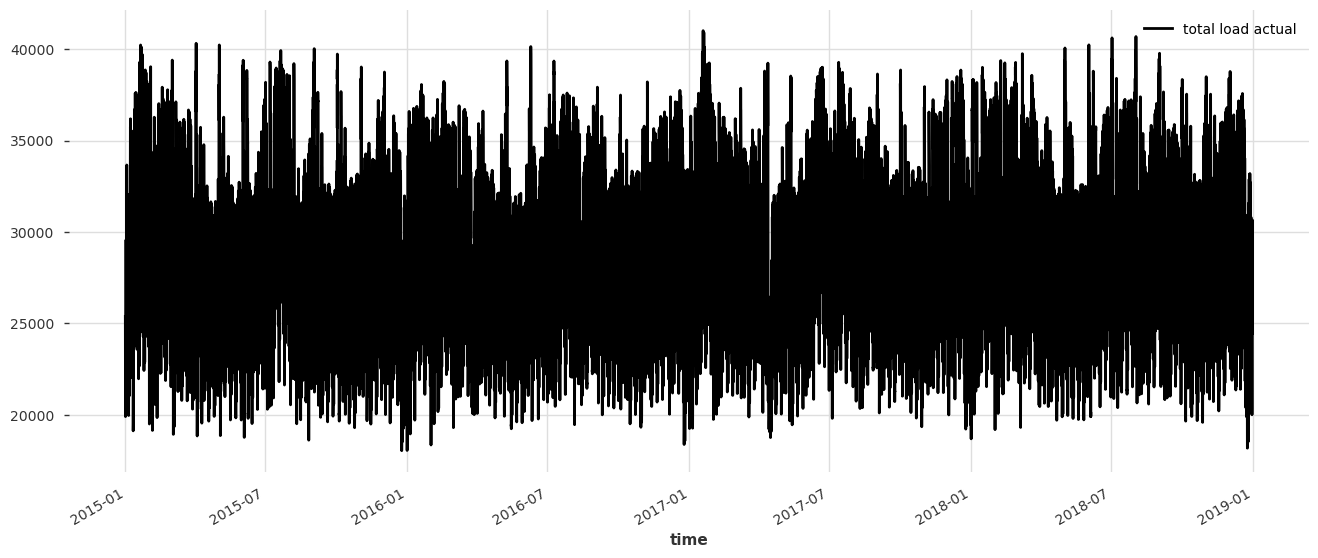

In [11]:
energy_data["total load actual"].plot();

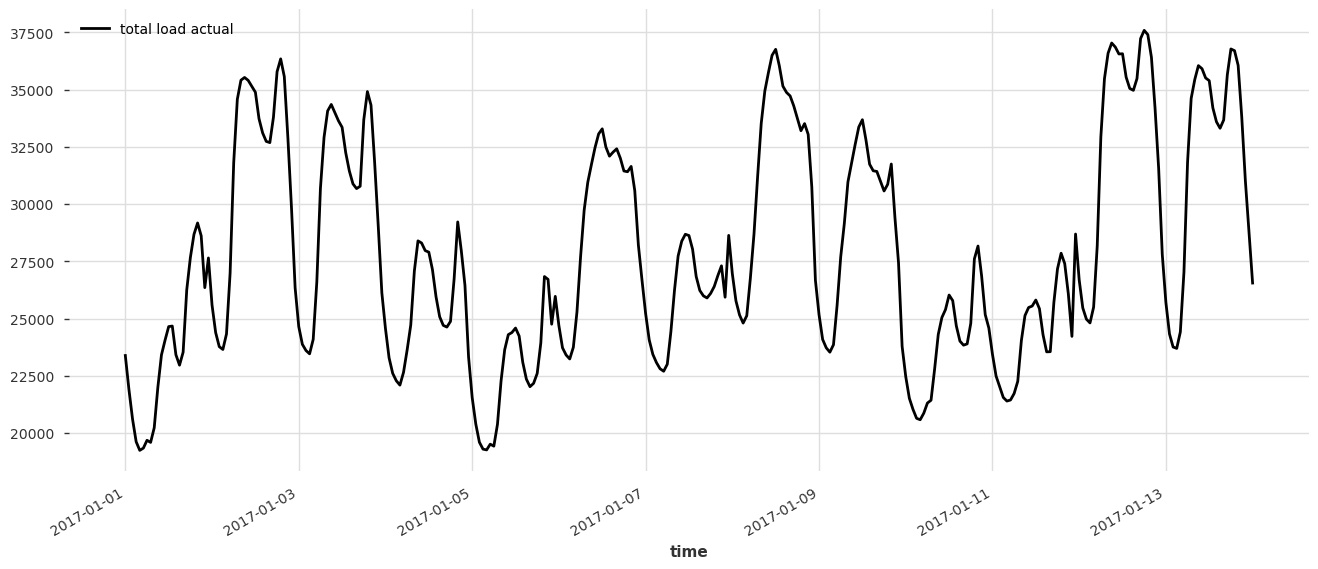

In [12]:
# plot a two-week slice
energy_data["total load actual"][pd.Timestamp("2017-01-01"):pd.Timestamp("2017-01-14")].plot();

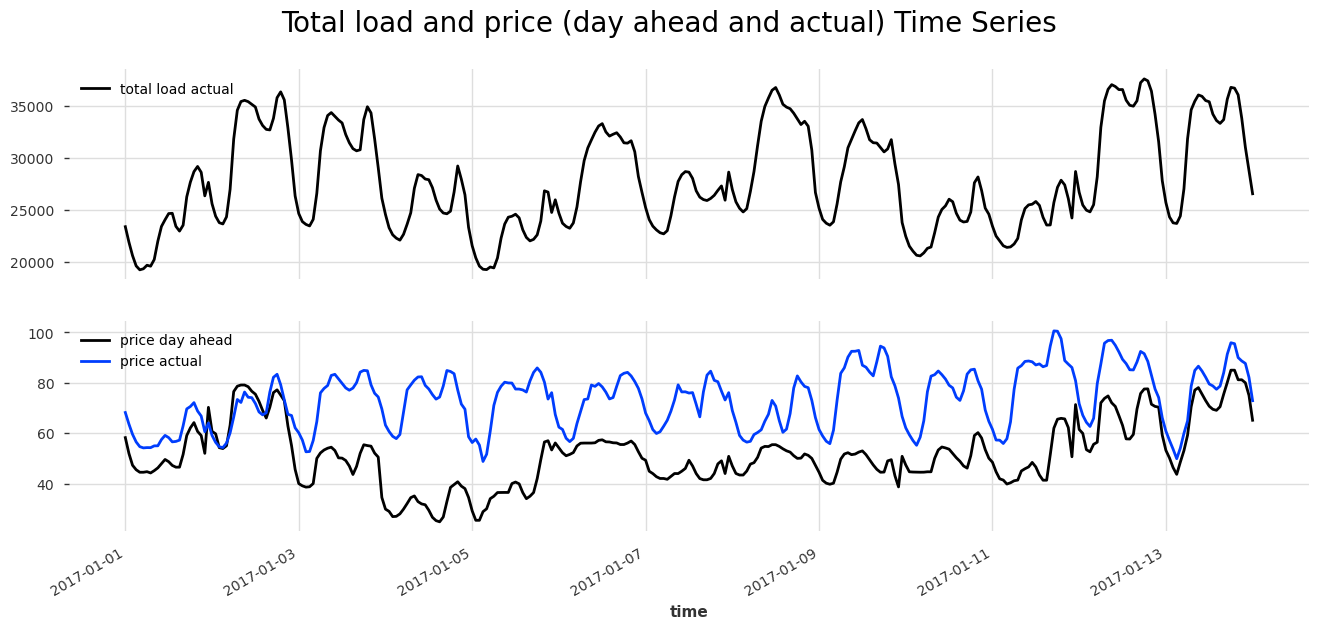

In [14]:
fig, axes = plt.subplots(2, 1, sharex=True)  # , layout="constrained"
timeframe = slice(pd.Timestamp("2017-01-01"), pd.Timestamp("2017-01-14"))
energy_data["total load actual"][timeframe].plot(ax=axes[0])
axes[0].set(xlabel=None)
energy_data[["price day ahead", "price actual"]][timeframe].plot(ax=axes[1])
fig.suptitle("Total load and price (day ahead and actual) Time Series", fontsize=20);

In [15]:
features = ["price day ahead", "price actual"]
target = "total load actual"
energy_df = energy_data[features + [target]].pd_dataframe()
energy_sample_df = energy_df.loc[timeframe]
energy_sample_df

component            price day ahead  price actual  total load actual
time                                                                 
2017-01-01 00:00:00            58.23         68.20            23393.0
2017-01-01 01:00:00            51.95         63.60            21909.0
2017-01-01 02:00:00            47.27         59.54            20615.0
2017-01-01 03:00:00            45.49         56.52            19628.0
2017-01-01 04:00:00            44.50         54.65            19252.0
...                              ...           ...                ...
2017-01-13 20:00:00            81.19         89.99            36061.0
2017-01-13 21:00:00            81.19         88.65            33806.0
2017-01-13 22:00:00            80.00         87.68            31023.0
2017-01-13 23:00:00            75.00         82.15            28770.0
2017-01-14 00:00:00            65.13         72.89            26558.0

[313 rows x 3 columns]

In [16]:
columns = ["total load actual", "price actual", "price day ahead"]
colors =["black", "blue", "darkcyan"]

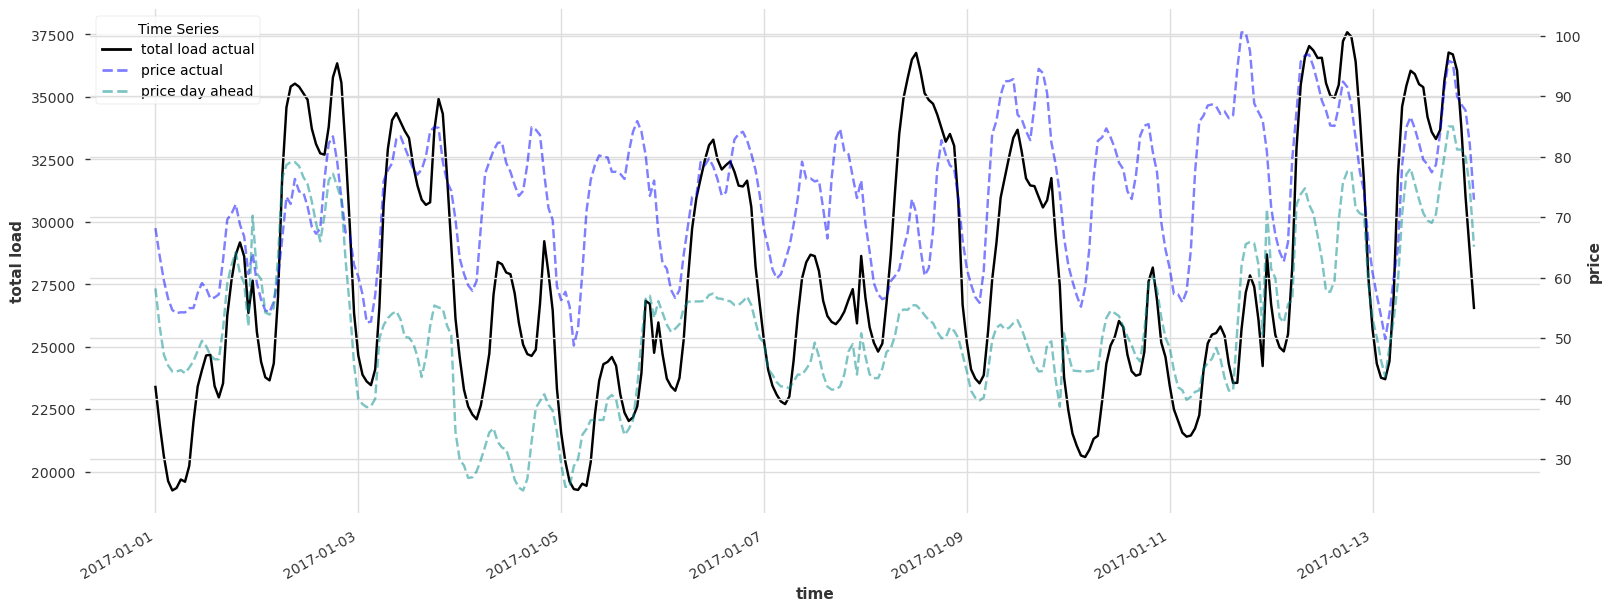

In [17]:
handles = []
fig, ax = plt.subplots(layout="constrained")
twin_ax = ax.twinx()
for column, color in zip(columns, colors):
    if column == "total load actual":
        ax.plot(energy_sample_df.index, energy_sample_df[column], color=color, label=column)
        handles.append(Line2D([], [], label=column, lw=2, color=color))
    else:
        twin_ax.plot(energy_sample_df.index, energy_sample_df[column], color=color, ls="--", alpha=0.5, label=column)
        handles.append(Line2D([], [], label=column, lw=2, ls="--", alpha=0.5, color=color))

twin_ax.set_ylabel("price")
ax.set_xlabel(xlabel="time")
# ax.set_xticks(rotation=45)
ax.set(ylabel="total load")
ax.legend(handles=handles, title="Time Series", frameon=True);
plt.gcf().autofmt_xdate();

## Train-Test Split
* set test periods as 2018 (entire year)

In [18]:
train_all_components, test_all_components = energy_data.split_before(pd.Timestamp("20180101"))

In [19]:
print(f"training periods: {train_all_components.start_time().strftime('%d/%m/%Y')}-{train_all_components.end_time().strftime('%d/%m/%Y')}")
print(f"test periods    : {test_all_components.start_time().strftime('%d/%m/%Y')}-{test_all_components.end_time().strftime('%d/%m/%Y')}")

training periods: 31/12/2014-31/12/2017
test periods    : 01/01/2018-31/12/2018


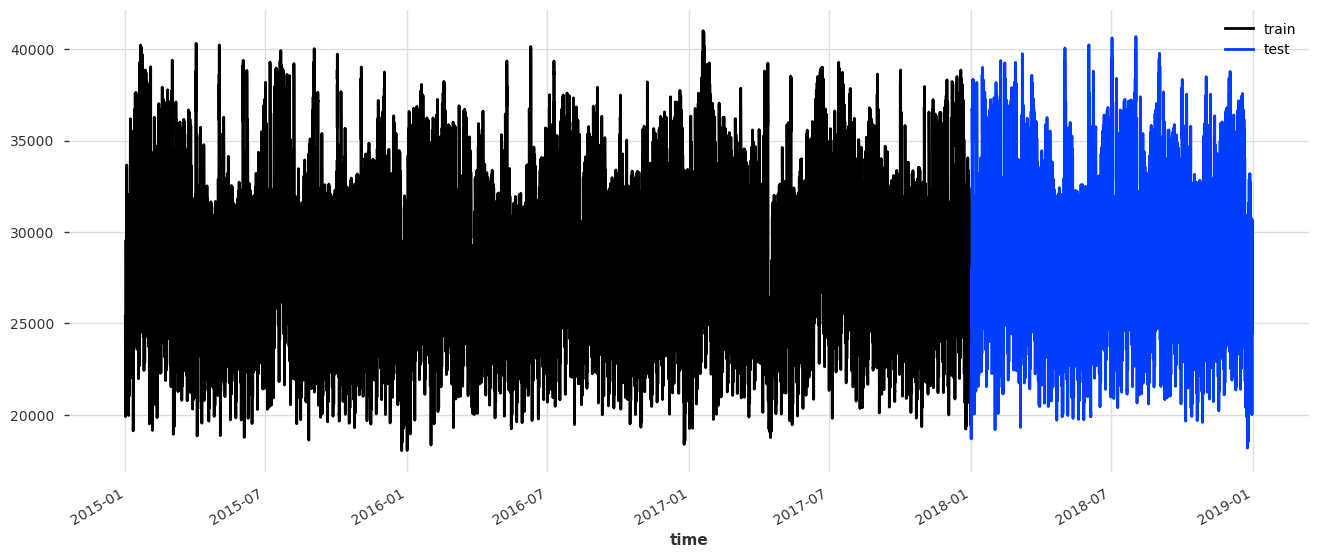

In [20]:
train_all_components[target].plot(label="train")
test_all_components[target].plot(label="test");

# Baseline Methods

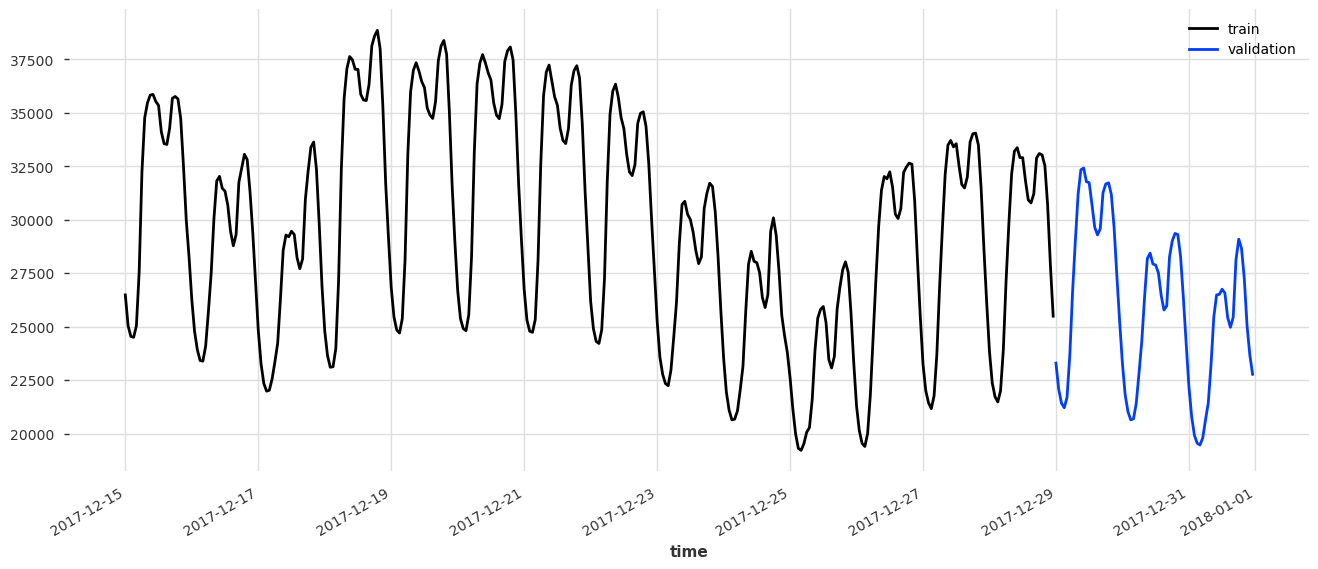

In [21]:
TRAIN_LEN, VAL_LEN = 14 * 24, 3 * 24  # take 14 days for train, and two days for validation
train_short = train_all_components[target][-TRAIN_LEN - VAL_LEN:-VAL_LEN]
validation_all_components = train_all_components[-VAL_LEN:]
validation = train_all_components[target][-VAL_LEN:]
train_short.plot(label="train")
validation.plot(label="validation");

In [22]:
print(f"training duration : {train_short.duration}\nvalidation duration: {validation.duration}")

training duration : 13 days 23:00:00
validation duration: 2 days 23:00:00


# Naive Forecast

In [23]:
from darts.models import NaiveSeasonal
from darts.models import NaiveMean

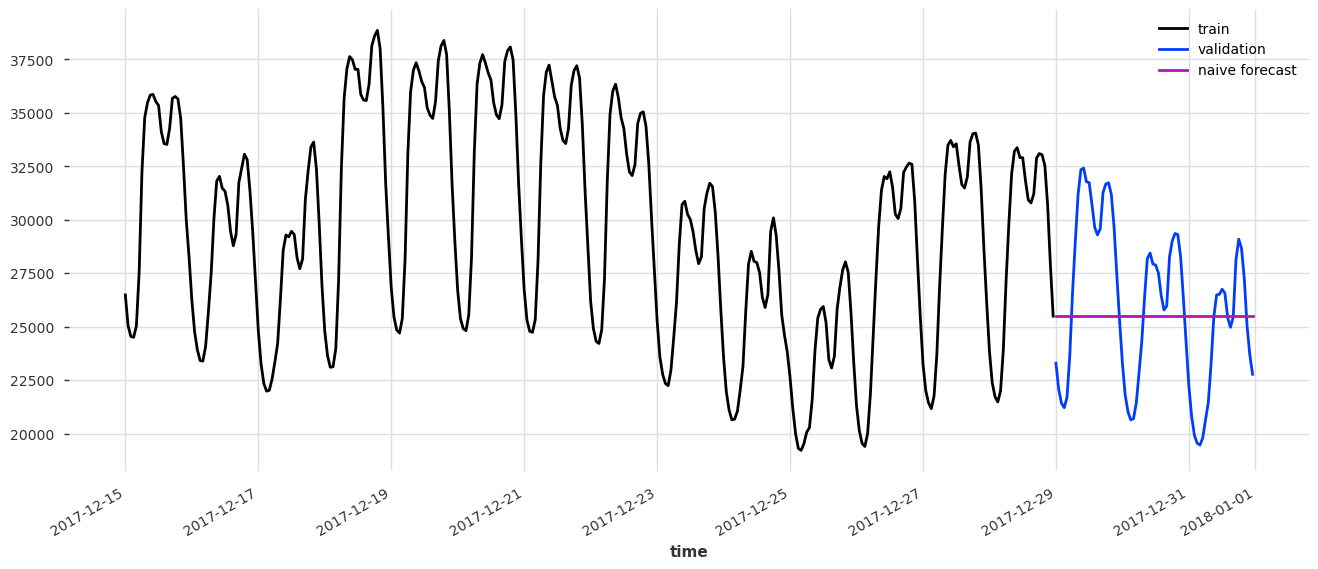

In [24]:
naive_model = NaiveSeasonal(K=1)  # repeat the last (observed) value
naive_model.fit(train_short)
naive_forecast = naive_model.predict(VAL_LEN)

train_short.plot(label="train")
validation.plot(label="validation")
naive_forecast.plot(label="naive forecast");

# Mean Forecast

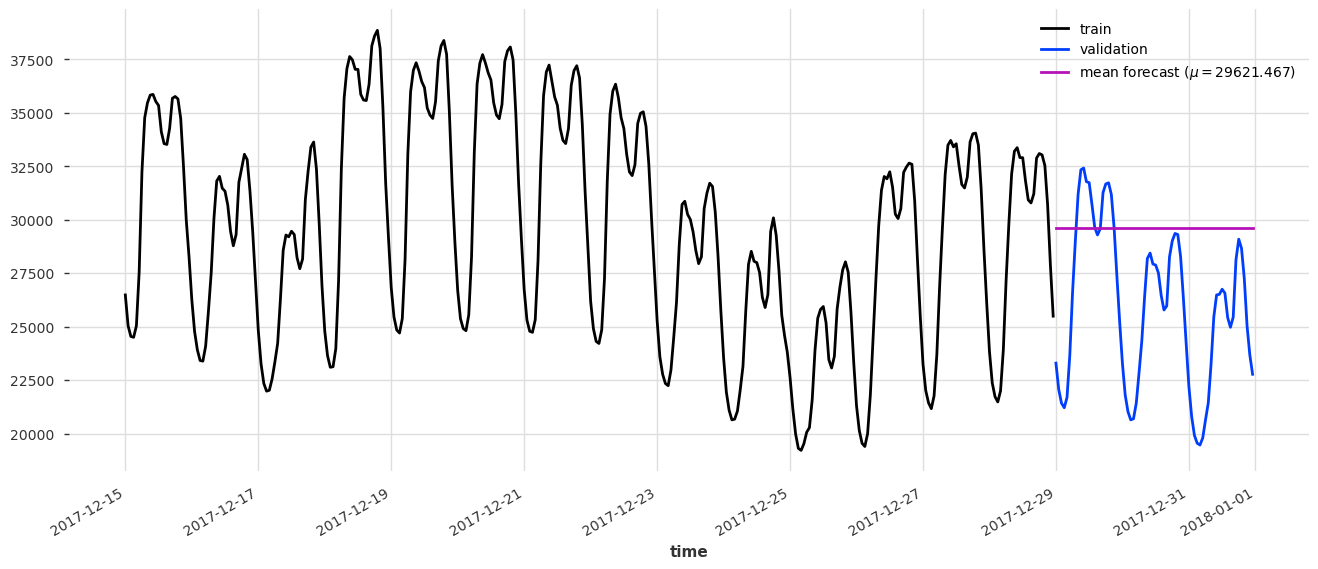

In [25]:
naive_mean = NaiveMean()  # predict the mean (observed) value
naive_mean.fit(train_short)
mean_forecast = naive_mean.predict(VAL_LEN)

train_short.plot(label="train")
validation.plot(label="validation")
mean_forecast.plot(label=fr"mean forecast ($\mu={mean_forecast.first_value():.3f}$)");

# Naive Seasonal Forecast

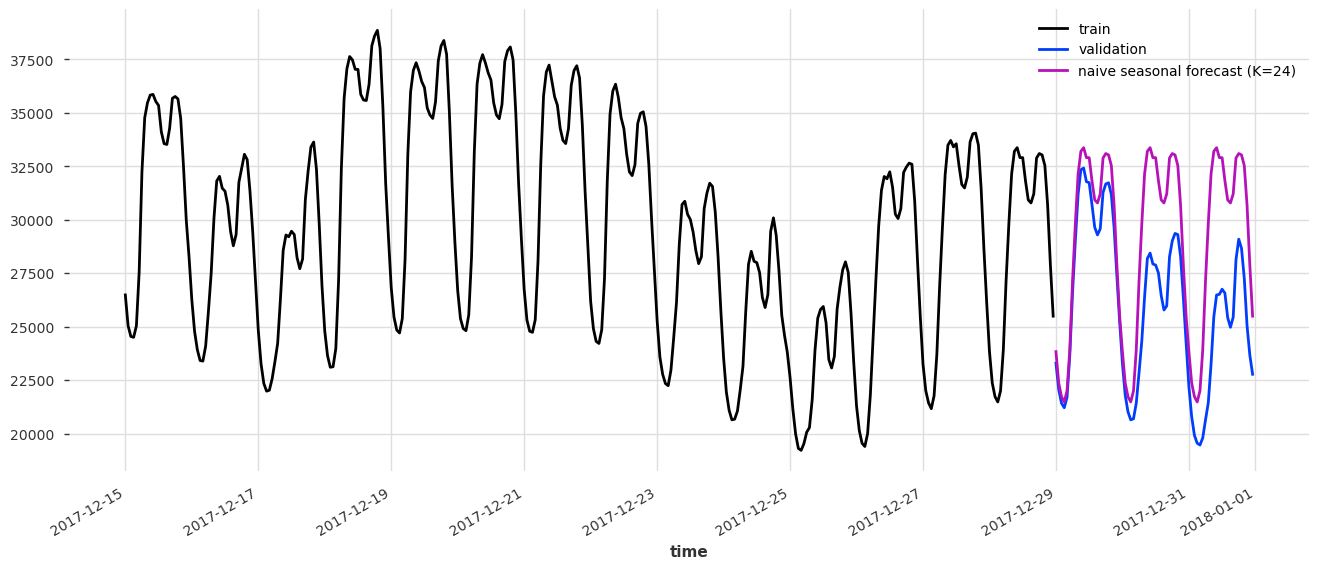

In [26]:
# prediction- copy the last (observed) value from the same hour
naive_seasonal_model = NaiveSeasonal(K=24)
naive_seasonal_model.fit(train_short)
naive_seasonal_forecast = naive_seasonal_model.predict(VAL_LEN)

train_short.plot(label="train")
validation.plot(label="validation")
naive_seasonal_forecast.plot(label="naive seasonal forecast (K=24)");

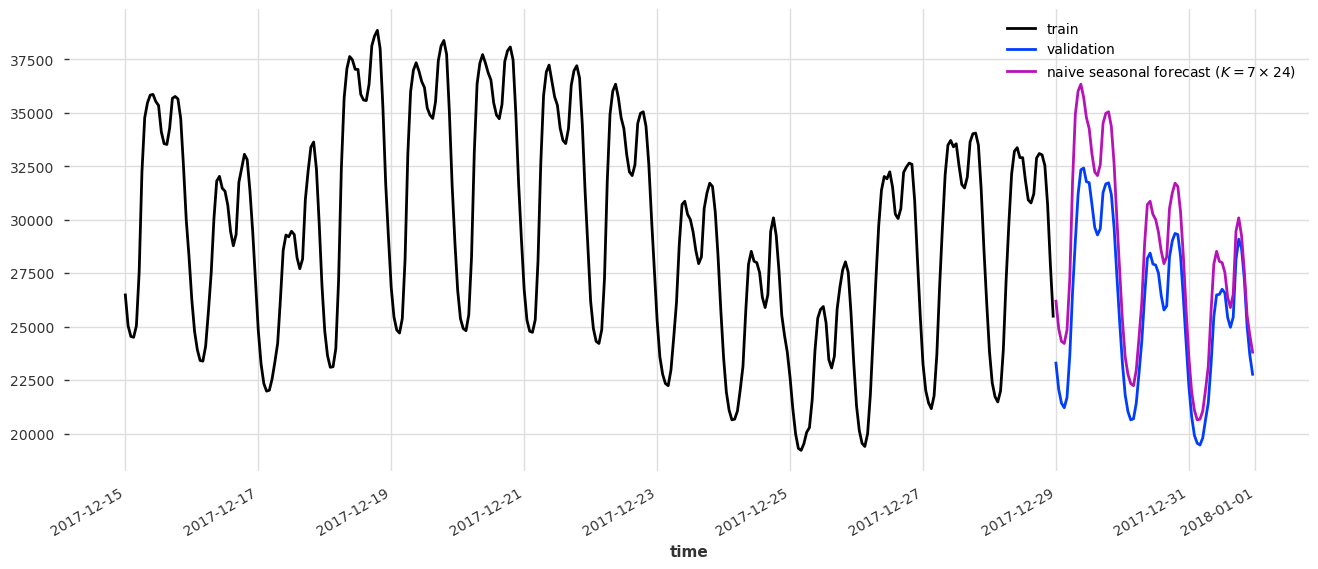

In [27]:
# copy the last value that was a week ago (same weekday and hour)
naive_seasonal_model = NaiveSeasonal(K=7*24)
naive_seasonal_model.fit(train_short)
naive_seasonal_forecast = naive_seasonal_model.predict(VAL_LEN)

train_short.plot(label="train")
validation.plot(label="validation")
ax = naive_seasonal_forecast.plot(label=r"naive seasonal forecast ($K=7 \times 24$)")
ax.legend(loc="upper right");

# Probabilistic Forecasters

## Climatological Forecast

In [28]:
class Climatological(LocalForecastingModel):
    def __init__(self):
        super().__init__()

    @property
    def supports_multivariate(self) -> bool:
        return True

    def _is_probabilistic(self):
        return True

    def fit(self, series: darts.TimeSeries):
        super().fit(series)

    def predict(self, n: int, num_samples: int = 1):
        """
        prediction- mean of random samples across each time step (n-#time steps)
        we can also compute quantiles, as we can treat the samples as the distribution across the training set in each time step
        """
        values = self.training_series.values().squeeze()  # ("time", "component") ->  ("time",)
        # sample (n, num_samples) (i.e., ("time", "sample")) finite values from training set
        samples = np.random.choice(values[np.isfinite(values)], (n, num_samples))
        # build a forecast based on "predictions" ("time", "component", "smaple"), and the original training set (component=1)
        return self._build_forecast_series(np.expand_dims(samples, axis=1), self.training_series)

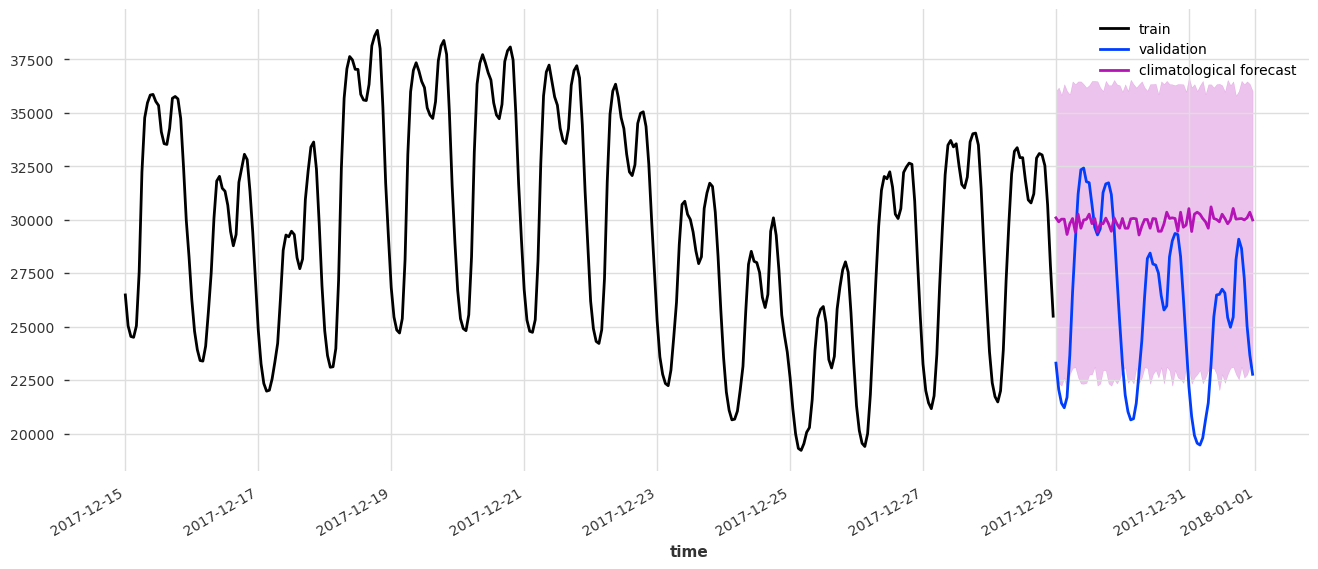

In [29]:
climatological_model = Climatological()
climatological_model.fit(train_short)
climatological_forecast = climatological_model.predict(VAL_LEN, num_samples=1000)

train_short.plot(label="train")
validation.plot(label="validation")
climatological_forecast.plot(label="climatological forecast", low_quantile=0.1, high_quantile=0.9);

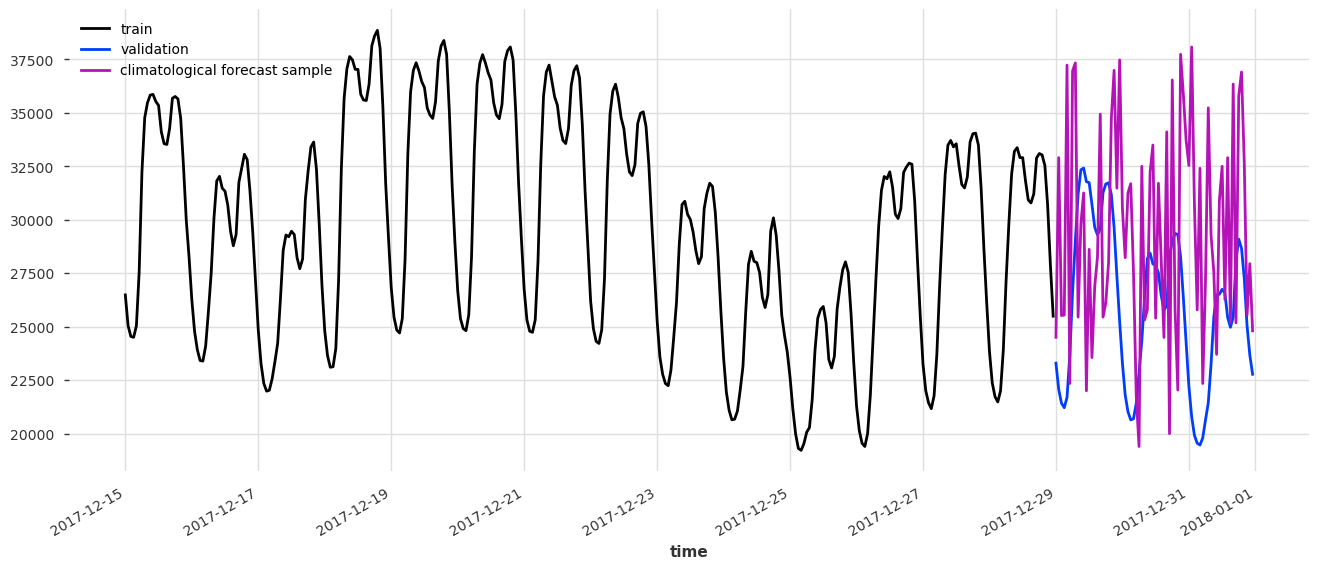

In [30]:
# plot a single "time series" sample
train_short.plot(label="train")
validation.plot(label="validation")
for i in range(1):
    climatological_forecast.sample(i).plot(label="climatological forecast sample")

## Tile Forecast

In [31]:
class ProbabilisticTileForecast(LocalForecastingModel):
    def __init__(self, K=7*24, num_tiles=None):
        super().__init__(add_encoders=True)
        self.K = K
        self.num_tiles = num_tiles

    @property
    def supports_multivariate(self):
        return True

    def _is_probabilistic(self):
        return True

    def fit(self, series: darts.TimeSeries):
        super().fit(series)

    def predict(self, n: int, num_samples: int = 0):
        """
        look at the empirical dist. of #tiles of the same seasonal period in the past
        * i.e., t, t - K, t - 2K,..., t - (num_tiles-1) * K for test example t + j * K
        """
        if self.num_tiles is None or self.num_tiles * self.K > self.training_series.n_timesteps:
            num_tiles = self.training_series.n_timesteps // self.K
        else:
            num_tiles = self.num_tiles
        # take last (num_tiles * K) observed values
        values = self.training_series.values().squeeze()[-num_tiles * self.K:]
        # readjust samples ("time", "component", "sample") from (num_tiles * K)
        # to (K, 1, num_tiles), 
        samples = np.expand_dims(values.reshape((num_tiles, self.K)).T, axis=1)
        # make ((n - 1) // self.K + 1) copies on the "time" axis 
        tiled_samples = np.tile(samples, ((n - 1) // self.K + 1, 1, 1))
        # final prediction- take the first n periods
        return self._build_forecast_series(tiled_samples[:n, :, :], self.training_series)

In [32]:
K=24
num_tiles=56
adjusted_num_tiles = train_short.n_timesteps // K
VAL_LEN
num_samples=1000
values = train_short.values().squeeze()[-adjusted_num_tiles * K:]
samples = np.expand_dims(values.reshape((adjusted_num_tiles, K)).T, axis=1)
print(f"values shape: {values.shape}")
print(f"samples shape{samples.shape}")

values shape: (336,)
samples shape(24, 1, 14)


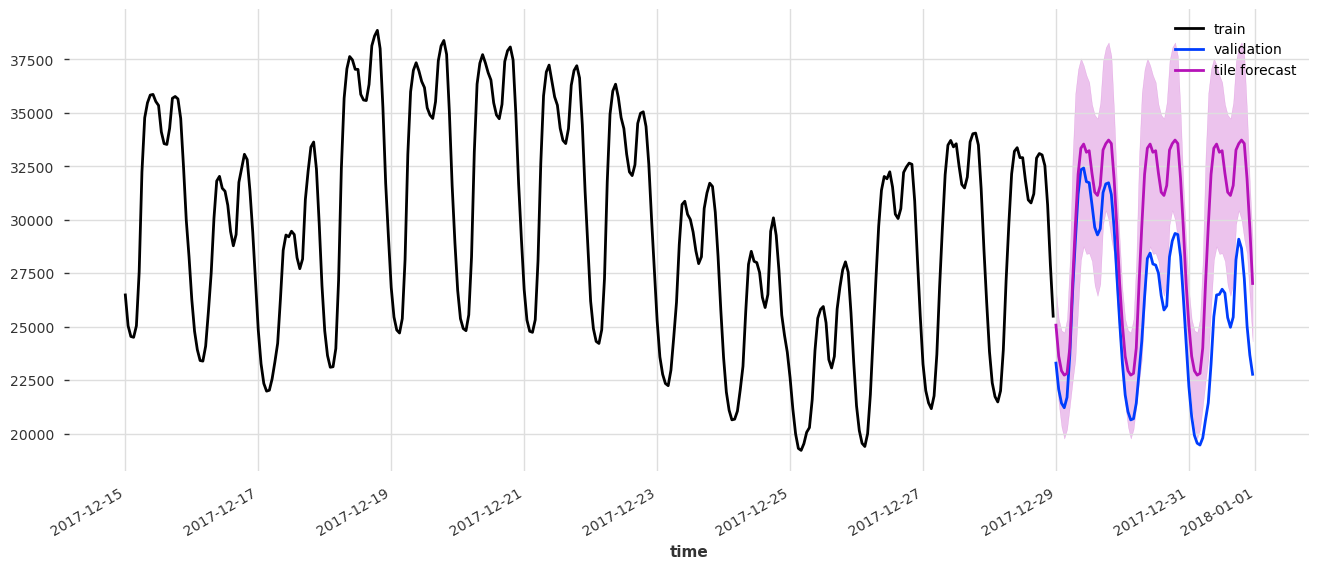

In [33]:
# for each hour (24), take the num_tiles (14) last training periods with the same hour
# to get an empirical dist.
tile_model = ProbabilisticTileForecast(K=24, num_tiles=56)
tile_model.fit(train_short)
tile_forecast = tile_model.predict(VAL_LEN, num_samples=1000)

train_short.plot(label="train")
validation.plot(label="validation")
tile_forecast.plot(label="tile forecast", low_quantile=0.1, high_quantile=0.9);

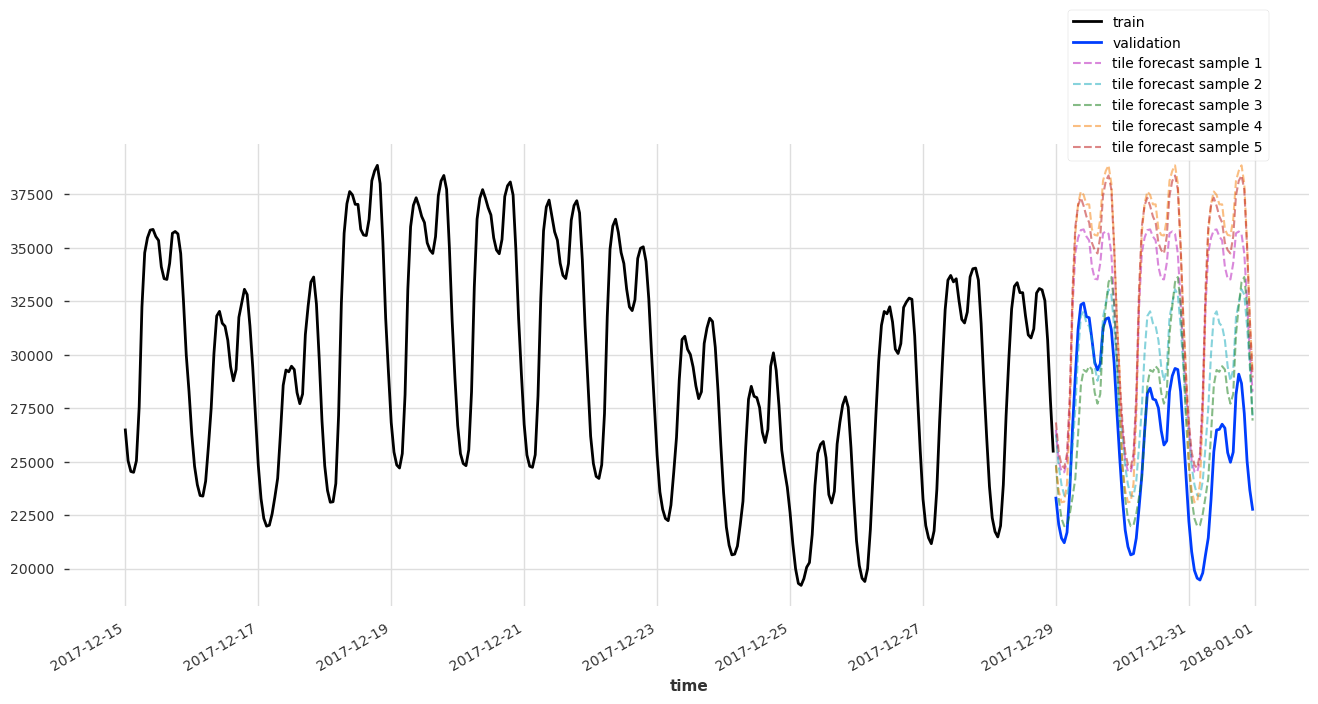

In [34]:
# plot a single "time series" sample
ax = train_short.plot(label="train")
ax = validation.plot(label="validation")
for i in range(5):
    ax = tile_forecast.sample(i).plot(label=f"tile forecast sample {i+1}", ls="--", lw=1.5, alpha=0.5)
ax.legend(bbox_to_anchor=(0.8, 0.95), frameon=True);  # bbox_to_anchor (upper left legend's location (1, 1)=upper left)

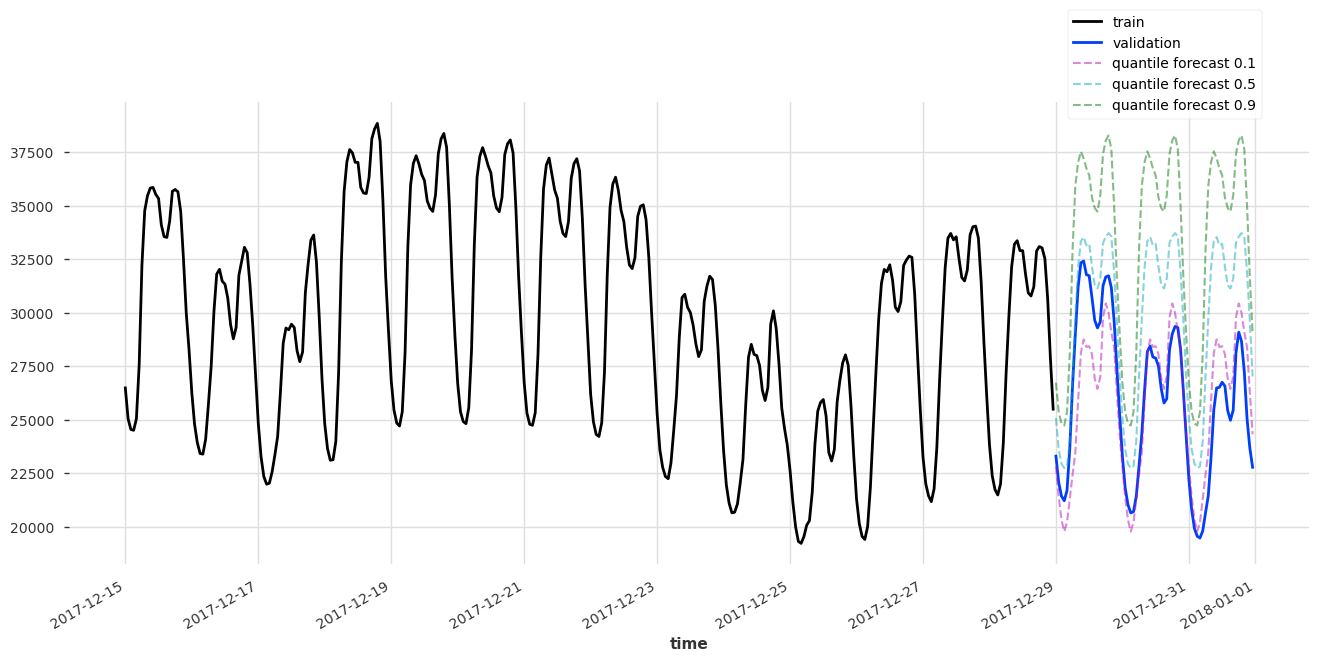

In [35]:
train_short.plot(label="train")
validation.plot(label="validation")
quantiles = [0.1, 0.5, 0.9]
for quantile in quantiles:
    ax = tile_forecast.quantile_timeseries(quantile).plot(label=f"quantile forecast {quantile}", ls="--", lw=1.5, alpha=0.5)
ax.legend(bbox_to_anchor=(0.8, 0.95), frameon=True);  # bbox_to_anchor (upper left legend's location (1, 1)=upper left)

# Backtesting

In [36]:
train, test = energy_data["total load actual"].split_before(pd.Timestamp("20180101"))

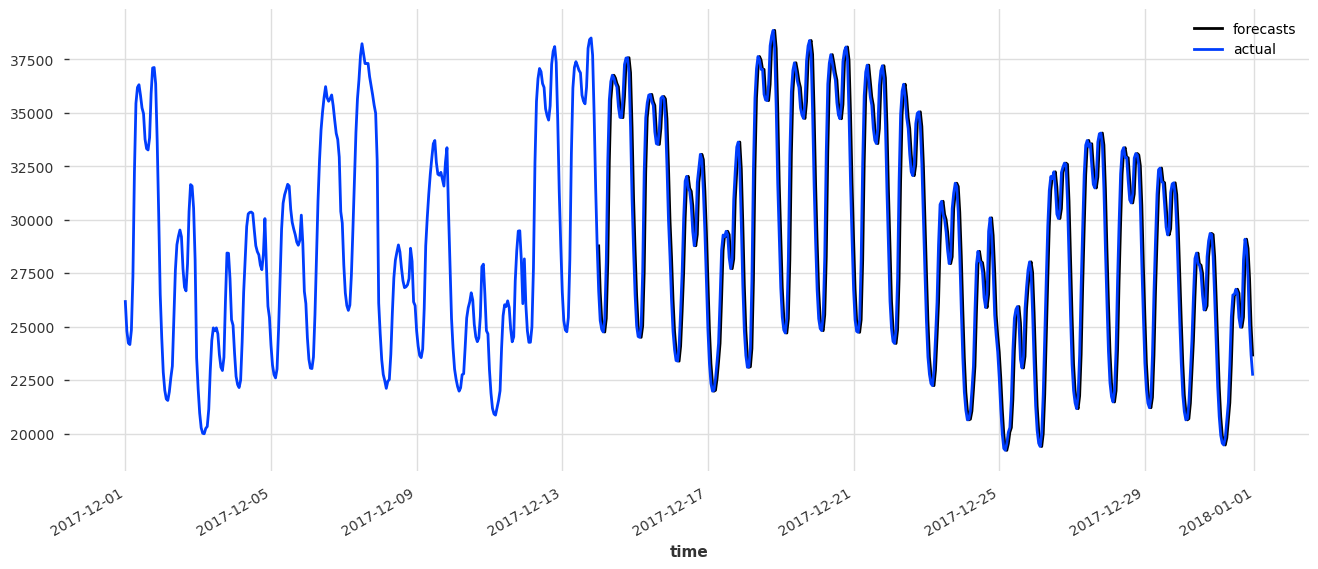

In [38]:
# list of one-step ahead forecasts (TimeSeries (1, 1, 1))
fct = darts.models.NaiveSeasonal(K=1).historical_forecasts(
    train, 
    start=pd.Timestamp("2017-12-14"),  # first date (timestamp) to predict from
    last_points_only=False,
    stride=1,
    forecast_horizon=1)
# concatenate list of predictions: ("time", "component", "sample") = (432, 1, 1)
fct_series = np.expand_dims(np.array([f.values()[0] for f in fct]), axis=2)
# set predictions into train (TimeSeries) object
train[pd.Timestamp("2017-12-14"):].with_values(fct_series).plot(label="forecasts")  # , lw=1.5, ls="--", alpha=0.5
train[-31*24:].plot(label="actual");

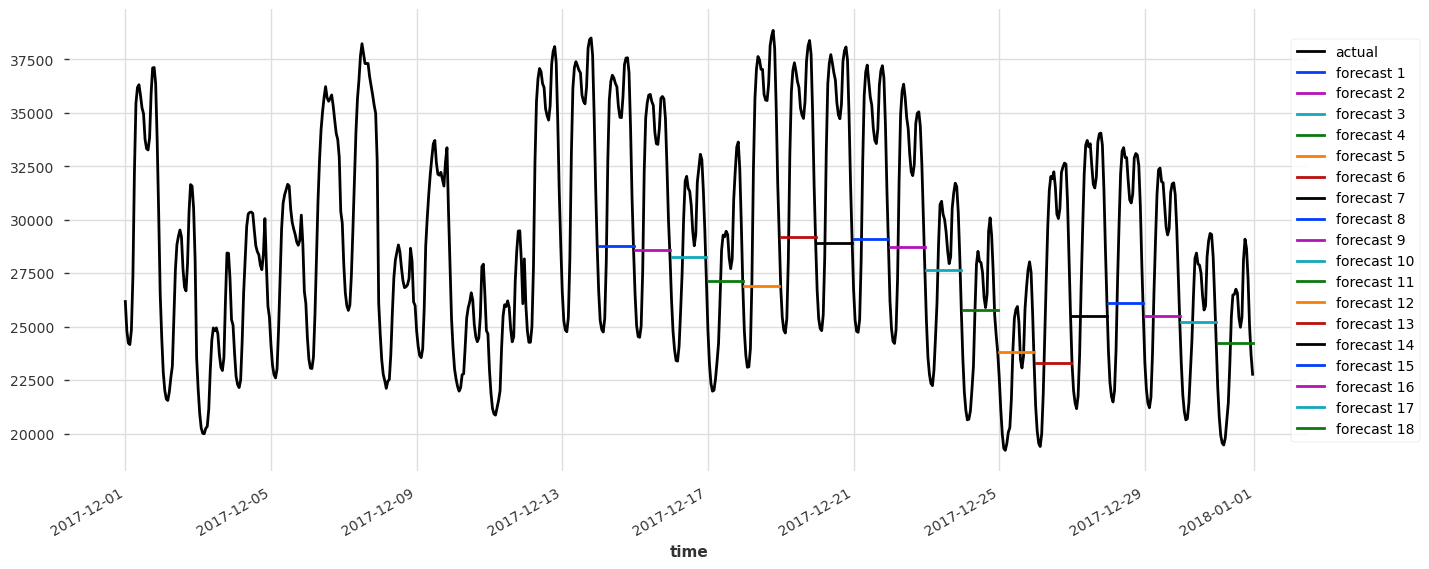

In [39]:
# point forecast (no CIs)
fct = darts.models.NaiveSeasonal(K=1).historical_forecasts(
    train,
    start=pd.Timestamp("2017-12-14"),
    last_points_only=False,
    stride=24,  # #(time steps) between two consecutive predictions.
    forecast_horizon=24)

train[-31*24:].plot(label="actual")
for i, f in enumerate(fct, 1):
    ax = f.plot(label=f"forecast {i}", central_quantile=0.5, high_quantile=None, low_quantile=None)  # , color=colors[i]

ax.legend(bbox_to_anchor=(0.98, 0.95), frameon=True);

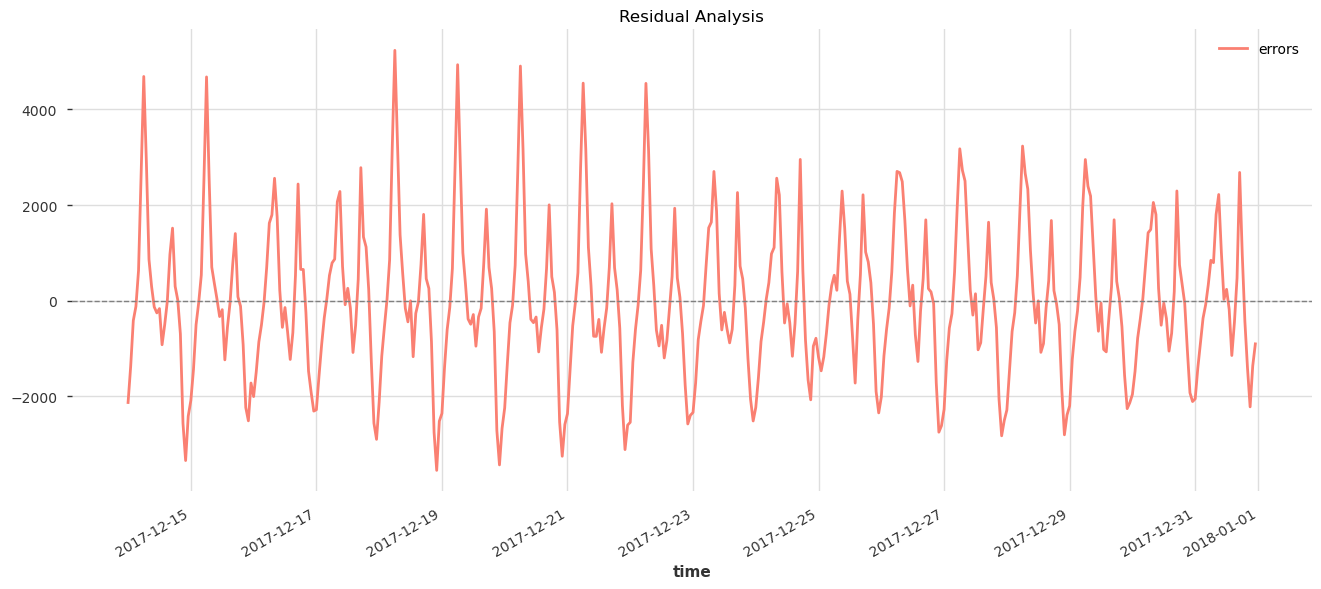

In [40]:
# Error Analysis
ax = (
    (train[pd.Timestamp("2017-12-14"):] - train[pd.Timestamp("2017-12-14"):].with_values(fct_series))
        .plot(label="errors", color="salmon")
)
ax.axhline(y=0, ls="--", lw=1, color="gray")
ax.set(title="Residual Analysis");

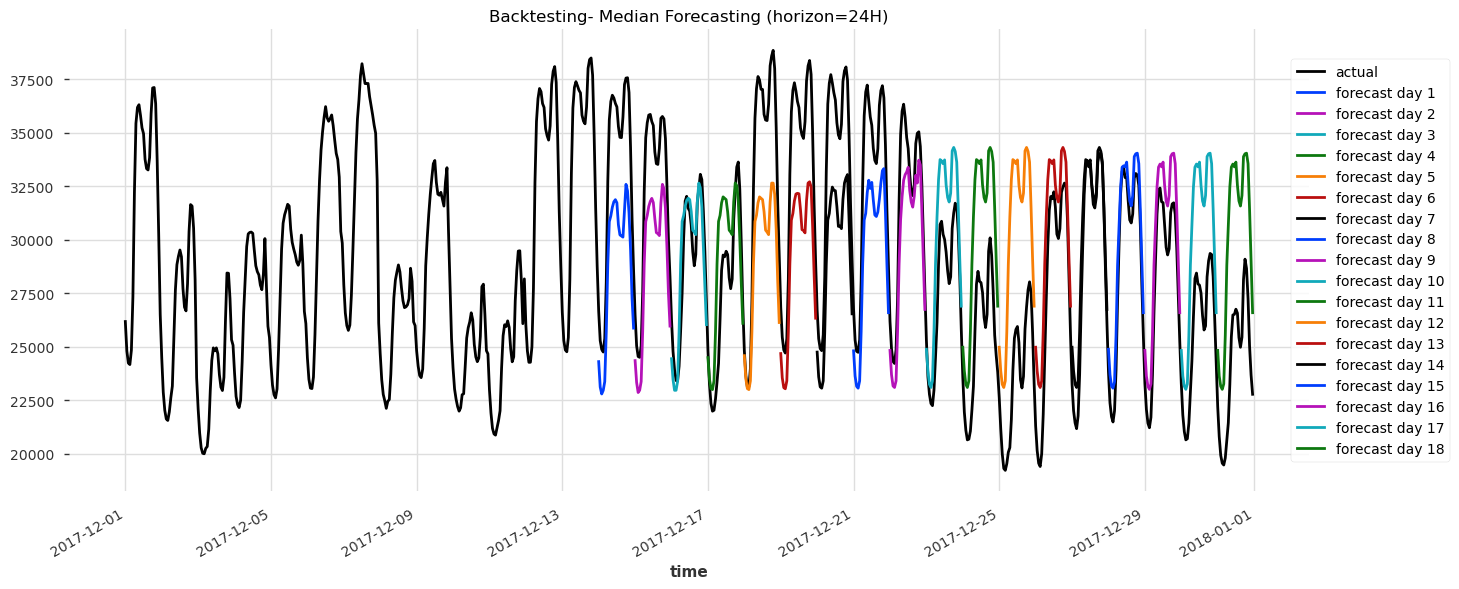

In [42]:
# Probabilistic Forecast
fct = tile_model.historical_forecasts(
    train,
    start=pd.Timestamp("2017-12-14"),
    last_points_only=False,
    stride=24,  # #(time steps) between two consecutive predictions (i.e, a single day).
    forecast_horizon=24)  # forecast 24 hours (a day)

train[-31*24:].plot(label="actual")
for i, f in enumerate(fct, 1):
    ax = f.plot(label=f"forecast day {i}", central_quantile=0.5, high_quantile=None, low_quantile=None)  # high_quantile=None, low_quantile=None, color=colors[i]

ax.legend(bbox_to_anchor=(0.98, 0.95), frameon=True)
ax.set(title="Backtesting- Median Forecasting (horizon=24H)");

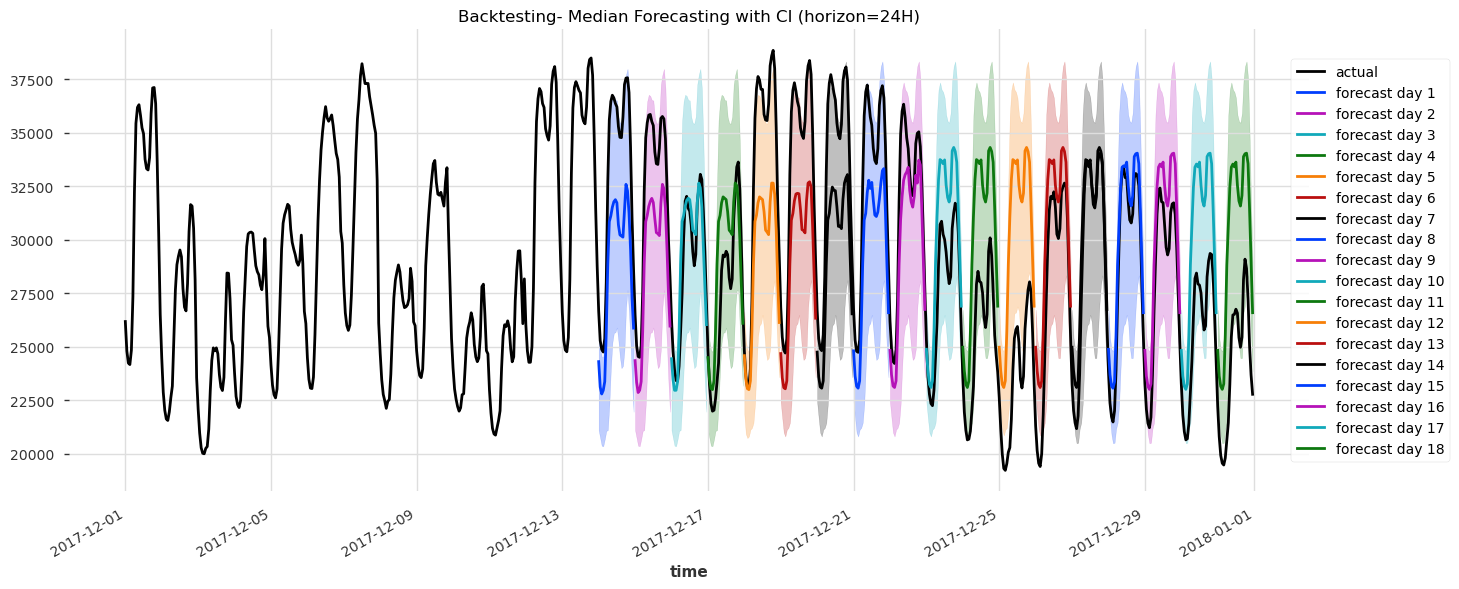

In [43]:
# add low (0.05) and high (0.95) quantiles
fct = tile_model.historical_forecasts(
    train,
    start=pd.Timestamp("2017-12-14"),
    last_points_only=False,
    stride=24,  # #(time steps) between two consecutive predictions (a single day).
    forecast_horizon=24)  # forecast horizon

train[-31*24:].plot(label="actual")
for i, f in enumerate(fct, 1):
    ax = f.plot(label=f"forecast day {i}", central_quantile=0.5)  

ax.legend(bbox_to_anchor=(0.98, 0.95), frameon=True)
ax.set(title="Backtesting- Median Forecasting with CI (horizon=24H)");

# Linear Regression

In [44]:
from darts.models import LinearRegressionModel, RegressionModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries, holidays_timeseries
from darts.models.forecasting.sf_auto_arima import StatsForecastAutoARIMA
from sklearn.linear_model import QuantileRegressor

In [45]:
train_short.duration, validation.duration

(Timedelta('13 days 23:00:00'), Timedelta('2 days 23:00:00'))

In [46]:
train_and_val = train_short.concatenate(validation)
train_and_val.duration

Timedelta('16 days 23:00:00')

## Trend Feature
* time represented as float over the range [0, 1] (across train and validation!!!)
* `lags_future_covariates=[0]`- use the current time ($0^{\text{th}}$ lag)

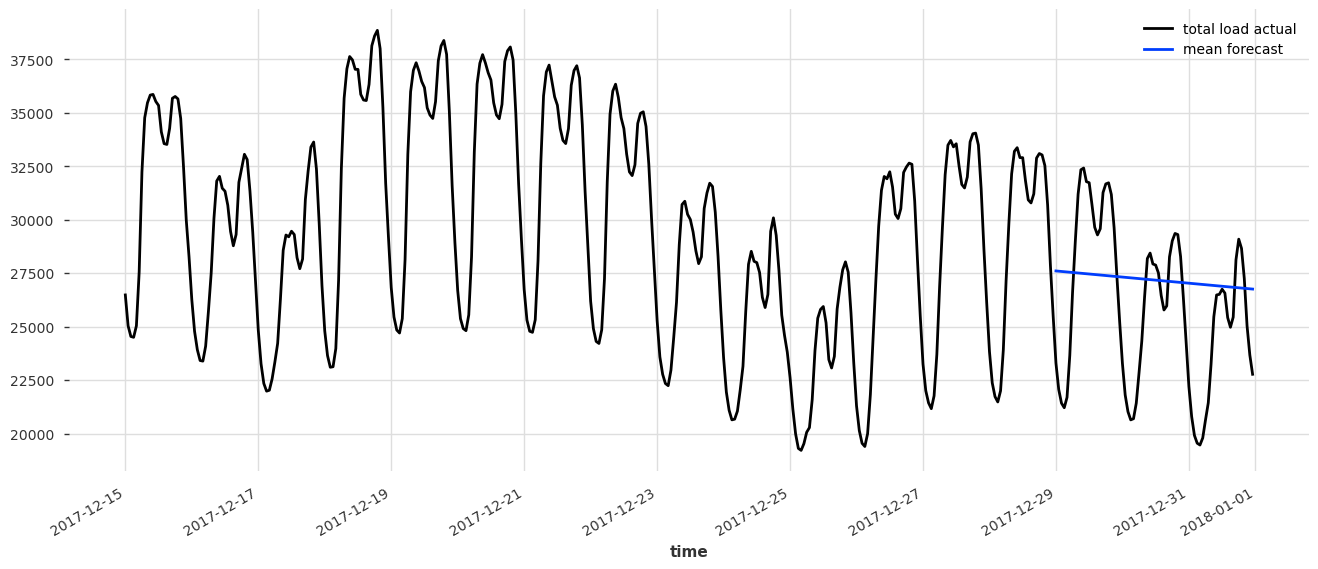

In [47]:
# trend feature - time represented as float over the range [0, 1] (across train and validation!!!)
trend_feature = darts.TimeSeries.from_times_and_values(
    train.time_index,
    np.linspace(0, 1, train.n_timesteps))
linear_regression = LinearRegressionModel(lags_future_covariates=[0])  # use the 0^th lag (current time )
linear_regression.fit(train_short,  future_covariates=trend_feature)
train_and_val.plot()
# forecasting (validation horizon), given time feature (available on validation as well)
linear_regression.predict(VAL_LEN, future_covariates=trend_feature).plot(label="mean forecast");

## One-hot Encoding Features
* `hour`- 24 one-hot vectors
* `day-of-week`- 7 one-hot vectors
* `holiday`- hoildays in spain
    * a single vector 
    * indicator (1 if holiday, 0 O.W.)

In [48]:
# one-hot encoding for hour feature ("time", "component", "sample") = (train_time, 24, 1)
hour_of_day = datetime_attribute_timeseries(train.time_index, "hour", one_hot=True)
# concatenate time feature with hour one-hot encoding
future_covariates = darts.concatenate([trend_feature, hour_of_day], axis="component")
print((
    "futrue covariate shape ('time', 'component', 'sample') = "
    f"{future_covariates.n_timesteps, future_covariates.n_components, future_covariates.n_samples}")
)

futrue covariate shape ('time', 'component', 'sample') = (26305, 25, 1)


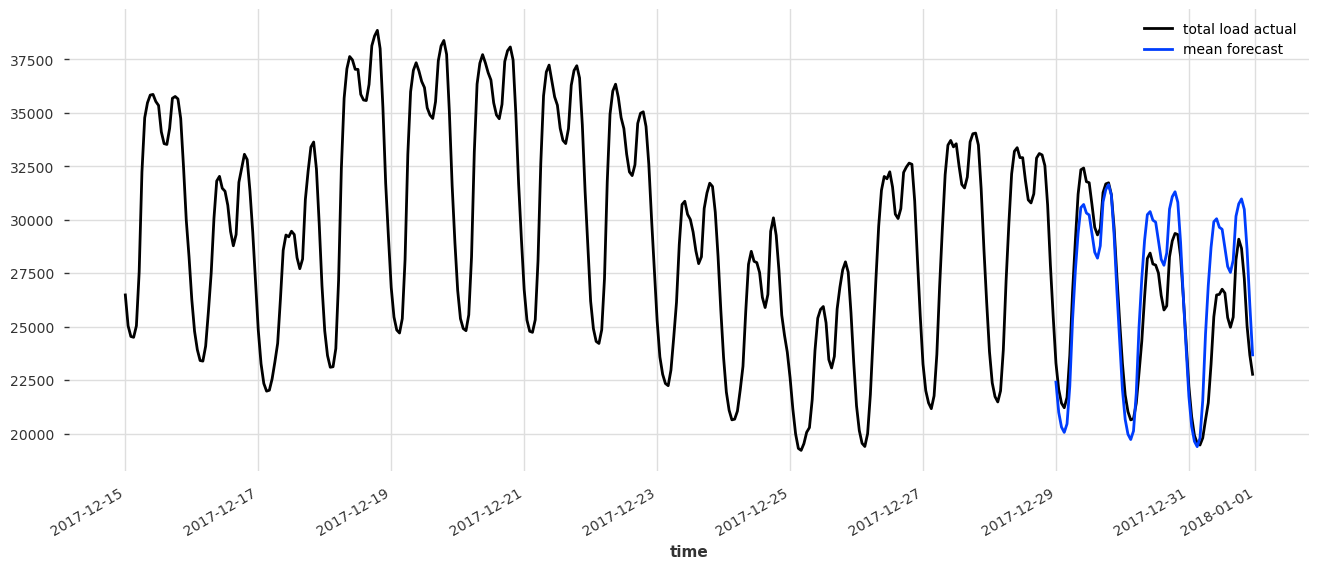

In [49]:
# linear regression with time feature and hour one-hot encoding
linear_regression.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
linear_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(label="mean forecast");

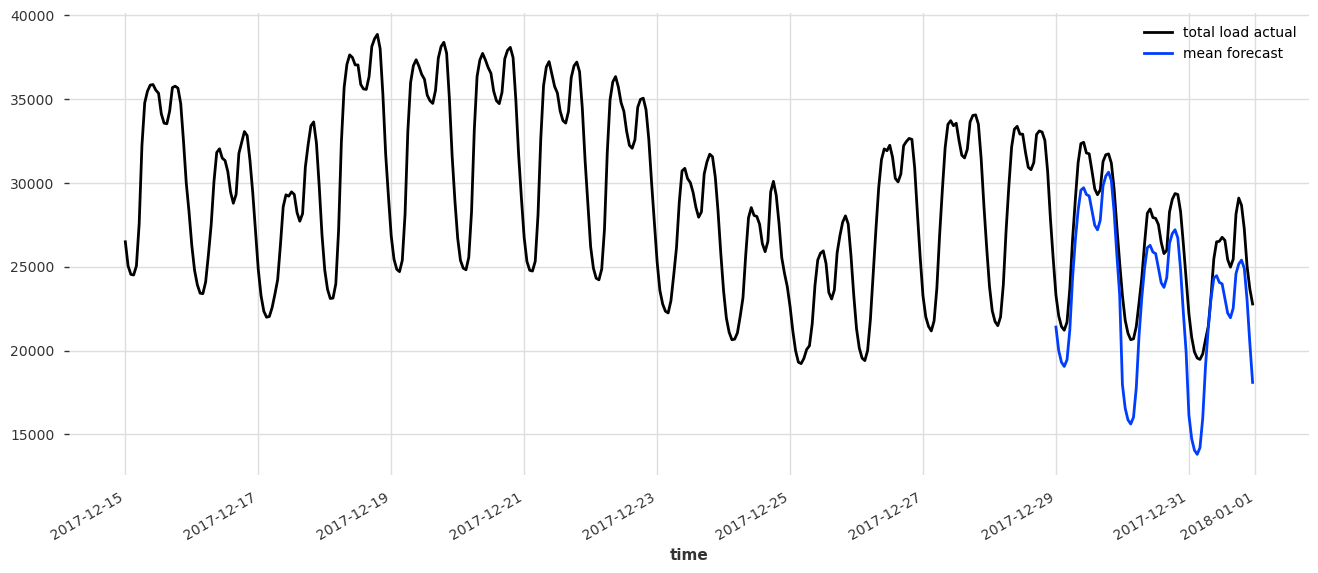

In [50]:
# adding day of week to features (component)
day_of_week = datetime_attribute_timeseries(train.time_index, "dayofweek", one_hot=True)
future_covariates = darts.concatenate([trend_feature, hour_of_day, day_of_week], axis="component")
linear_regression.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
linear_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(label="mean forecast");

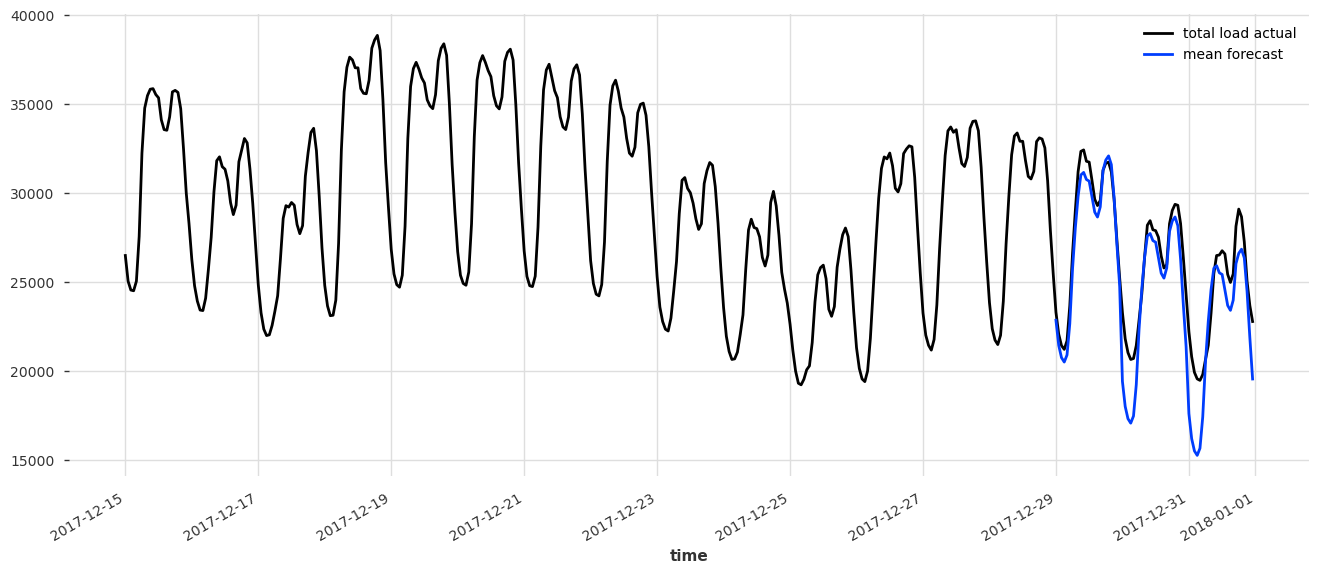

In [51]:
# add holiday (indicator) feature (1 if holiday, 0 O.W.)
holidays = holidays_timeseries(train.time_index, country_code="ES")  # holidays in spain
future_covariates = darts.concatenate([trend_feature, hour_of_day, day_of_week, holidays], axis="component")
linear_regression.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
linear_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(label="mean forecast");

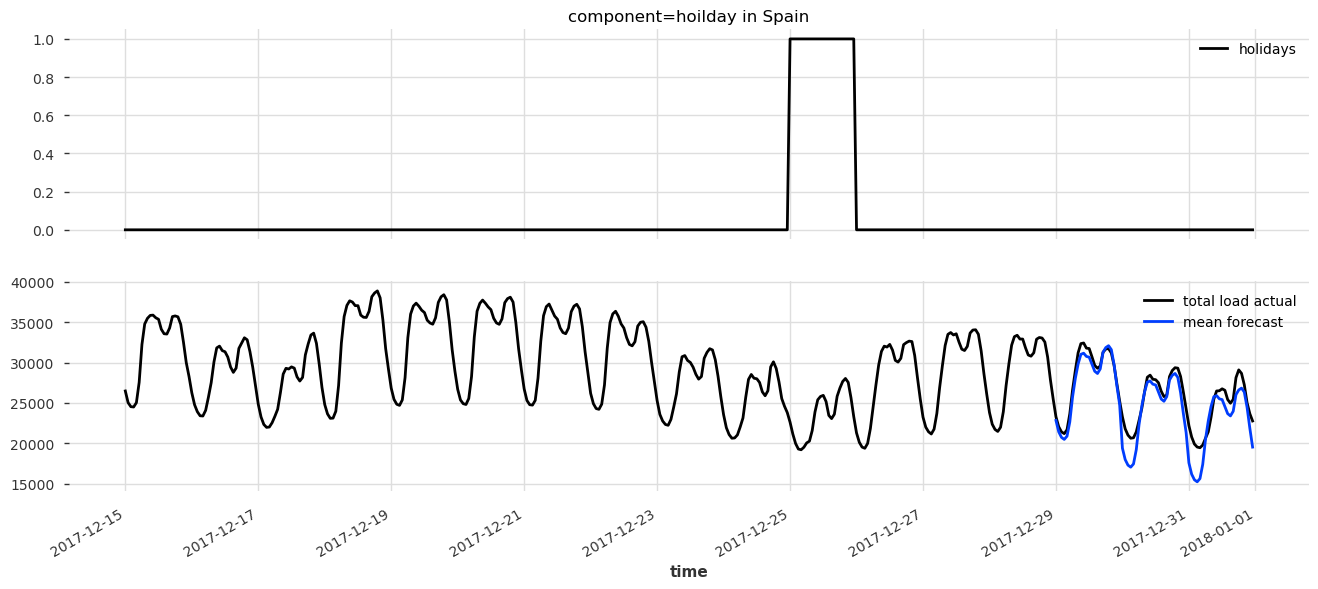

In [53]:
# add holiday (indicator) feature (1 if holiday, 0 O.W.)
holidays = holidays_timeseries(train.time_index, country_code="ES")  # holidays in spain
future_covariates = darts.concatenate([trend_feature, hour_of_day, day_of_week, holidays], axis="component")
linear_regression.fit(train_short, future_covariates=future_covariates)

fig, axes = plt.subplots(2, 1, sharex=True)
holidays[-train_and_val.n_timesteps:].plot(ax=axes[0])
axes[0].set(xlabel=None, title="component=hoilday in Spain")
train_and_val.plot(ax=axes[1])
linear_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(ax=axes[1], label="mean forecast");

## Lags
* $l$ lags- $l$ last target values

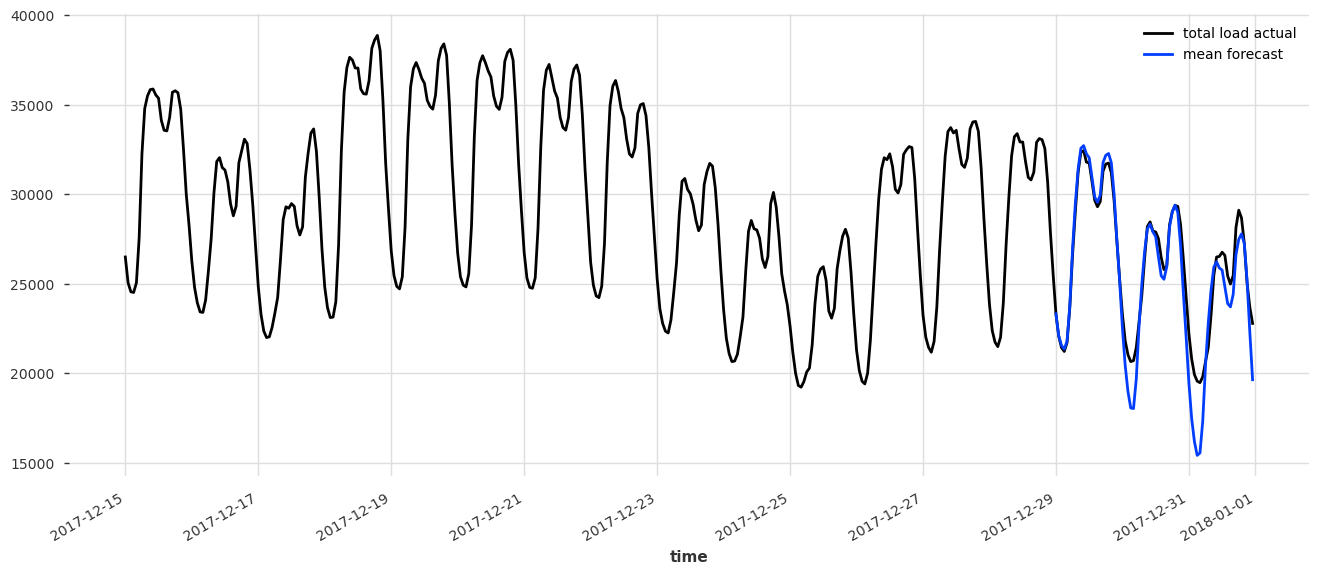

In [54]:
# lags=48: add the (target) values from the past 48 hours (48 timesteps)
linear_regression = LinearRegressionModel(lags_future_covariates=[0], lags=48)  # adaptive to the 48 hours
future_covariates = darts.concatenate([trend_feature, hour_of_day, day_of_week, holidays], axis="component")
linear_regression.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
linear_regression.predict(VAL_LEN, future_covariates=future_covariates).plot(label="mean forecast");

## Poisson Regression
* same features with Poisson likelihood

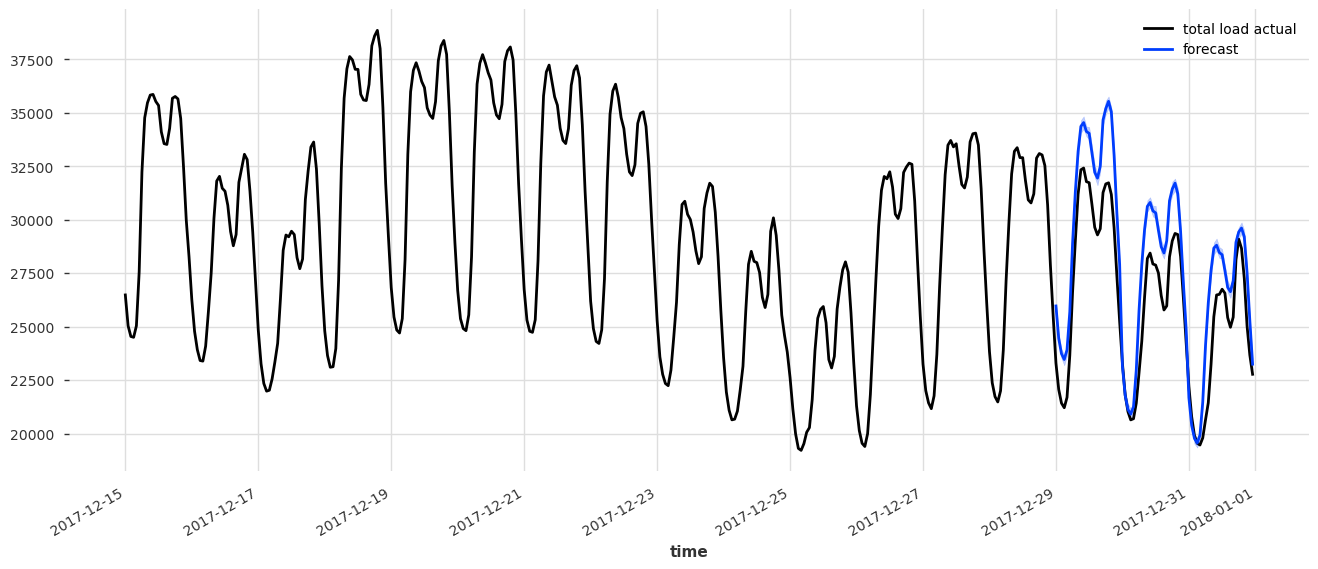

In [55]:
linear_regression = LinearRegressionModel(lags_future_covariates=[0], likelihood="poisson")
linear_regression.fit(train_short, future_covariates=future_covariates)

train_and_val.plot()
prediction = linear_regression.predict(VAL_LEN, future_covariates=future_covariates, num_samples=100)
prediction.plot(label="forecast");

## Quantile Regression
* same features with quantile (pinball) loss function

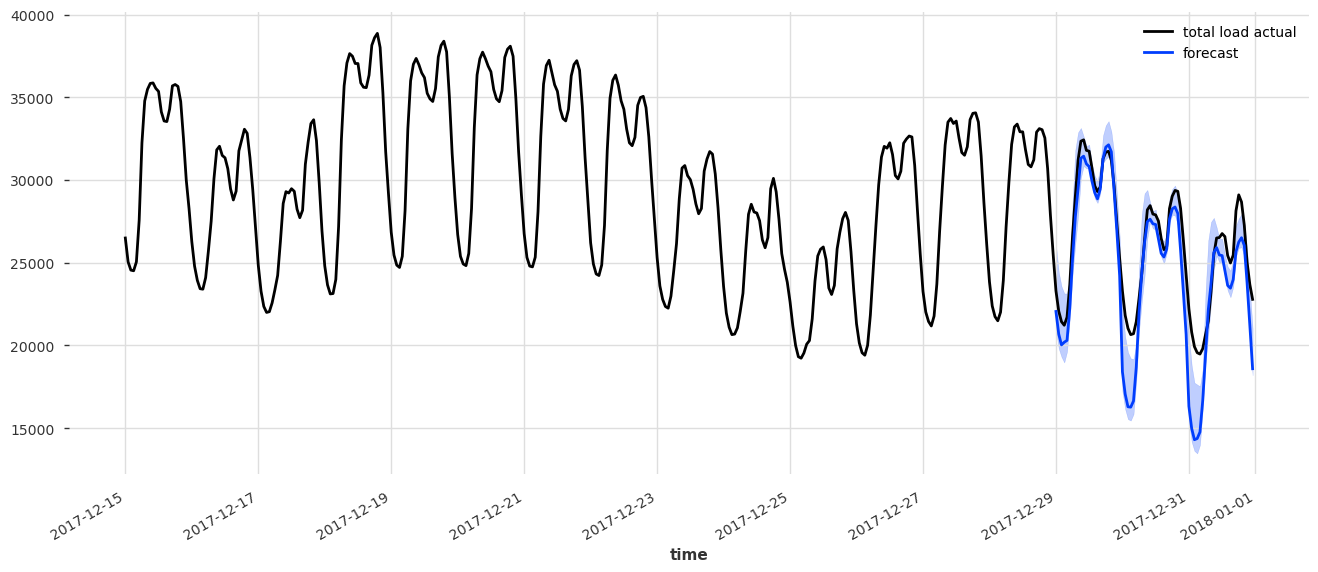

In [56]:
linear_regression = LinearRegressionModel(lags_future_covariates=[0], likelihood="quantile", alpha=0)
linear_regression.fit(train_short, future_covariates=future_covariates)

train_and_val.plot()
prediction = linear_regression.predict(VAL_LEN, future_covariates=future_covariates, num_samples=100)
prediction.plot(label="forecast");

In [57]:
DAY_AHEAD_PRICE_FACTOR = 1.26
critical_ratio_extrinsic = (DAY_AHEAD_PRICE_FACTOR - 1) / DAY_AHEAD_PRICE_FACTOR
critical_ratio_extrinsic

0.20634920634920637

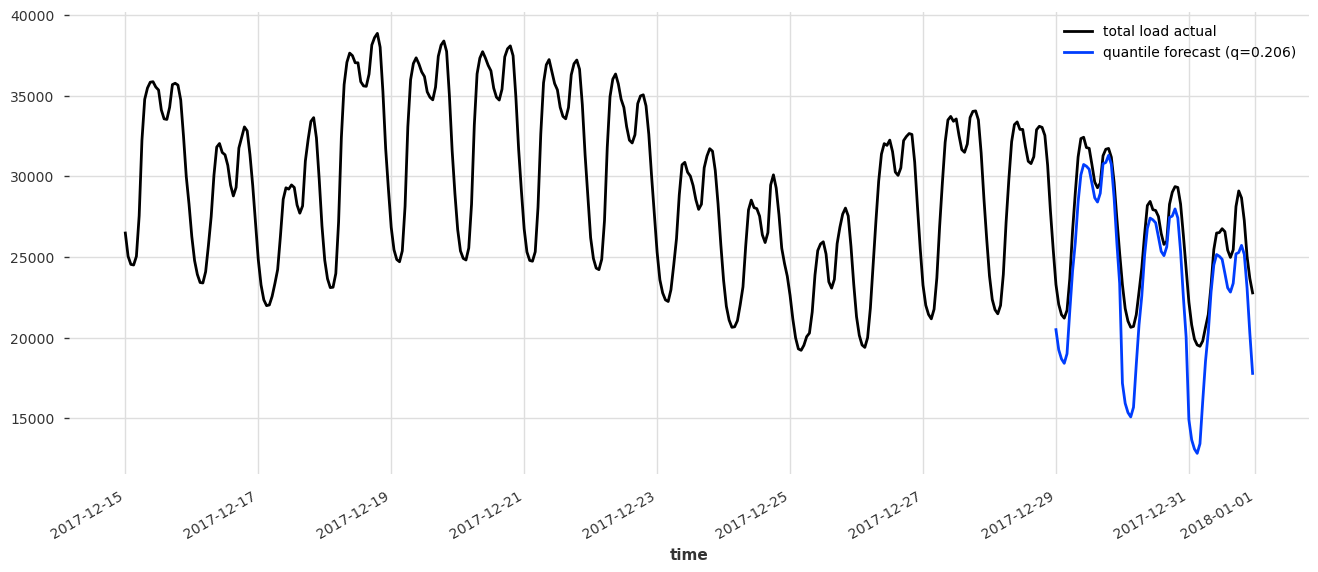

In [59]:
# quantile regression using scikit-learn QuantileRegressor model (specific quantile)
quantile_regression = RegressionModel(
    lags_future_covariates=[0],
    model=QuantileRegressor(
        quantile=critical_ratio_extrinsic,
        alpha=1e-5,  # regularization constant that multiplies the L1 penalty term.
        solver="highs")
)
quantile_regression.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
(
    quantile_regression
        .predict(VAL_LEN, future_covariates=future_covariates)
        .plot(label=f"quantile forecast (q={critical_ratio_extrinsic:.3f})")
);

# Evaluation

In [60]:
def eval_intrinsic_single(forecast: TimeSeries, observed: TimeSeries, rho: float) -> dict[str, float]:
    return {
        "MAE": darts.metrics.mae(observed['total load actual'], forecast),
        "wQL-crit": quantile_loss(observed['total load actual'], forecast, rho=critical_ratio_extrinsic)
    }

def eval_intrinsic(forecasts: list[TimeSeries], observed: TimeSeries, rho: float) -> pd.DataFrame:
    metrics = []
    for forecast in forecasts:
        # restrict both series to common time points
        forecast_common = forecast.slice_intersect(observed)
        observed_common = observed.slice_intersect(forecast)
        metric = eval_intrinsic_single(forecast_common, observed_common, rho)
        metrics.append(metric)
    return pd.DataFrame(metrics)

In [61]:
tile_forecasts = tile_model.historical_forecasts(
    train, 
    start=pd.Timestamp("2016-12-14"), 
    last_points_only=False, 
    stride=24, 
    forecast_horizon=24)

climatological_forecasts = climatological_model.historical_forecasts(
    train, 
    start=pd.Timestamp("2016-12-14"), 
    last_points_only=False, 
    stride=24, 
    forecast_horizon=24,
    num_samples=1000)

qr_forecasts = quantile_regression.historical_forecasts(
    train, 
    start=pd.Timestamp("2017-12-14"), 
    last_points_only=False, 
    stride=24, 
    forecast_horizon=24,
    future_covariates=future_covariates,
    train_length=14*24)  # train_length=14*24

In [62]:
tile_intrinsic = (
    eval_intrinsic(tile_forecasts, train, rho=critical_ratio_extrinsic)
        .rename(lambda x: "tile_"+x, axis=1)
)

climatological_intrinsic = (
    eval_intrinsic(climatological_forecasts, train, rho=critical_ratio_extrinsic)
        .rename(lambda x: "clim_"+x, axis=1)
)

qr_intrinsic = (
    eval_intrinsic(qr_forecasts, train, rho=critical_ratio_extrinsic)
        .rename(lambda x: "qr_" + x, axis=1)
)

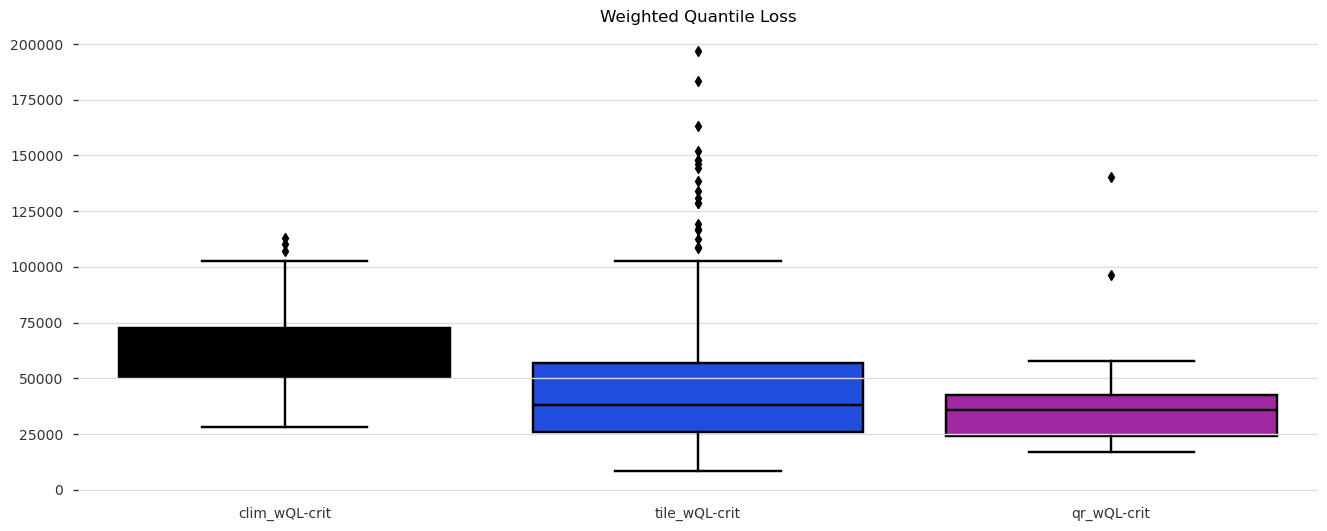

In [64]:
# mean weighted quantile loss = empirical CRPS
results = pd.concat([climatological_intrinsic, tile_intrinsic, qr_intrinsic], axis=1)
ax = sns.boxplot(results.filter(regex="crit", axis=1))
ax.set(title="Weighted Quantile Loss");

In [65]:
results.head()

clim_MAE  clim_wQL-crit     tile_MAE  tile_wQL-crit       qr_MAE  \
0  5157.645833   80039.242630  2860.729167   58384.732678  1963.166667   
1  5478.625000   80104.639456  2806.500000   59352.792139  2427.041667   
2  5151.416667   79168.099773  2438.458333   56619.058201   855.583333   
3  2883.687500   49242.761905  1475.375000   20735.402872  5409.791667   
4  3219.666667   57810.063492  2772.791667   22988.241875  9719.625000   

    qr_wQL-crit  
0  30417.841270  
1  24039.269841  
2  22299.428571  
3  53582.698413  
4  96270.571429

In [66]:
models = ["clim", "tile", "qr"]
pd.concat(
    [(
        results.filter(like="MAE", axis=1).mean()
            .rename("Mean MAE")
            .set_axis(models)),
     (
         results.filter(like="wQL-crit", axis=1)
             .mean()
             .rename("Mean Quantile Loss")
             .set_axis(models))],
    axis=1
)

Mean MAE  Mean Quantile Loss
clim  3916.043917        61811.490820
tile  2446.973643        45249.459600
qr    2565.980324        42804.151675

# ARIMA

<Axes: xlabel='time'>

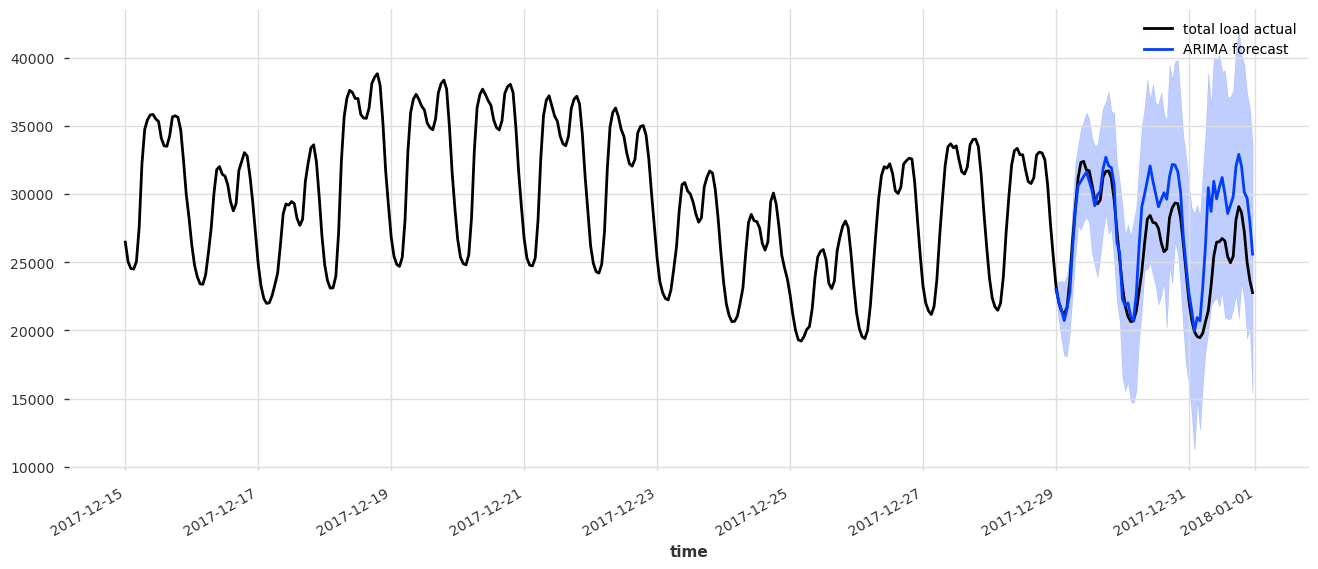

In [67]:
auto_arima = StatsForecastAutoARIMA()
auto_arima.fit(train_short, future_covariates=future_covariates)
train_and_val.plot()
auto_arima.predict(VAL_LEN, future_covariates=future_covariates, num_samples=100).plot(label="ARIMA forecast")